In [42]:
import numpy as np
import matplotlib.pyplot as plt

M = np.array([0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4], dtype=float)
L = np.array([0.15, 0.35, 1.00, 2.30, 4.10, 7.00, 11.2, 17.5, 25.0, 35.0], dtype=float)

m = M.size
m

10

## 1) Dataset visualization
We plot $M$ vs $L$ and comment on linearity.
Expect: luminosity increases **nonlinearly** with mass (main-sequence stars roughly follow $L \u223c M^{3-4}$), so a straight line will not capture the curve well.

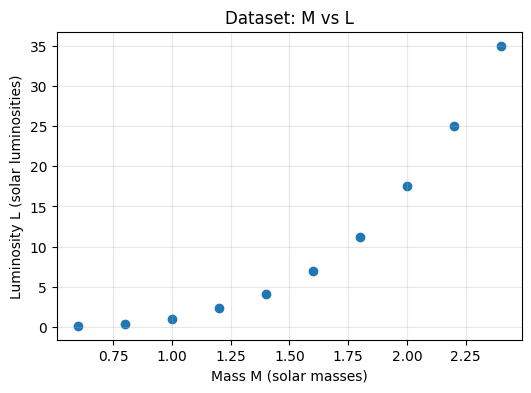

In [33]:
plt.figure(figsize=(6,4))
plt.scatter(M, L)
plt.xlabel('Mass M (solar masses)')
plt.ylabel('Luminosity L (solar luminosities)')
plt.title('Dataset: M vs L')
plt.grid(True, alpha=0.3)
plt.show()

## 2) Model and loss (MSE)
Prediction:
$$\hat{L}^{(i)} = w M^{(i)} + b$$
Cost (we use the common $\\2m$ version; it has the same minimizer as plain MSE):
$$J(w,b)=\frac{1}{2m}\sum_{i=1}^{m}(\hat{L}^{(i)}-L^{(i)})^2$$

In [43]:
def predict_lin(M, w, b):
    return w * M + b

def cost_mse_half(M, y, w, b):
    yhat = predict_lin(M, w, b)
    err = yhat - y
    return float((err @ err) / (2 * y.size))

cost_mse_half(M, L, w=0.0, b=0.0)

117.69675

## 3) Cost surface (mandatory)
We evaluate $J(w,b)$ on a grid and plot a contour map.
The minimum on this surface corresponds to the best-fitting parameters $(w,b)$ for this linear model.

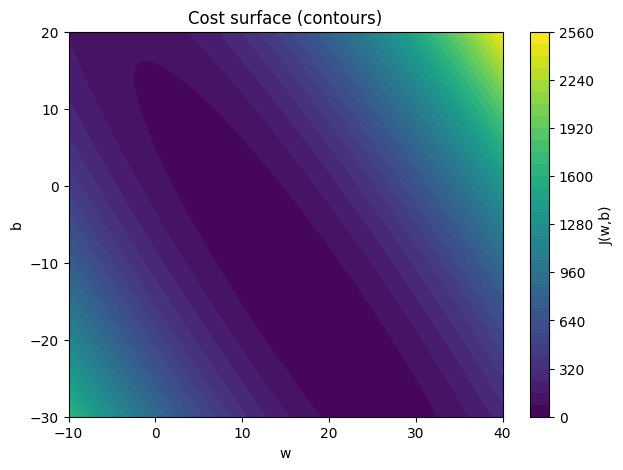

In [35]:
w_vals = np.linspace(-10, 40, 200)
b_vals = np.linspace(-30, 20, 200)
W, B = np.meshgrid(w_vals, b_vals)

J = np.zeros_like(W)
for i in range(J.shape[0]):
    for j in range(J.shape[1]):
        J[i, j] = cost_mse_half(M, L, W[i, j], B[i, j])

plt.figure(figsize=(7,5))
cs = plt.contourf(W, B, J, levels=40)
plt.colorbar(cs, label='J(w,b)')
plt.xlabel('w')
plt.ylabel('b')
plt.title('Cost surface (contours)')
plt.show()

## 4) Gradients (derive + implement)
With $J(w,b)=\frac{1}{2m}\sum(\hat{L}-L)^2$ and $\hat{L}=wM+b$, the partial derivatives are:

$$\frac{\partial J}{\partial w} = \frac{1}{m}\sum_{i=1}^m (\hat{L}^{(i)}-L^{(i)})M^{(i)}$$
$$\frac{\partial J}{\partial b} = \frac{1}{m}\sum_{i=1}^m (\hat{L}^{(i)}-L^{(i)})$$
We implement gradients in two ways:
- **Non-vectorized**: explicit loop over samples (mandatory)
- **Vectorized**: NumPy operations (mandatory)

In [44]:
def grads_loop(M, y, w, b):
    m = y.size
    dw = 0.0
    db = 0.0
    for i in range(m):
        yhat = w * M[i] + b
        err = yhat - y[i]
        dw += err * M[i]
        db += err
    dw /= m
    db /= m
    return float(dw), float(db)

def grads_vec(M, y, w, b):
    yhat = w * M + b
    err = yhat - y
    dw = (err @ M) / y.size
    db = np.sum(err) / y.size
    return float(dw), float(db)

w0, b0 = 1.23, -0.7
dw1, db1 = grads_loop(M, L, w0, b0)
dw2, db2 = grads_vec(M, L, w0, b0)
dw1, db1, dw2, db2

(-19.3996, -9.215, -19.3996, -9.215)

## 5) Gradient descent (loop vs vectorized)
Update rule:
$$w \leftarrow w - \alpha \frac{\partial J}{\partial w}, \quad b \leftarrow b - \alpha \frac{\partial J}{\partial b}$$
We record the cost over iterations to study convergence.

In [45]:
def gradient_descent(M, y, lr=0.01, iters=2000, use_vectorized=True):
    w = 0.0
    b = 0.0
    history = []
    for _ in range(iters):
        if use_vectorized:
            dw, db = grads_vec(M, y, w, b)
        else:
            dw, db = grads_loop(M, y, w, b)
        w -= lr * dw
        b -= lr * db
        history.append(cost_mse_half(M, y, w, b))
    return float(w), float(b), np.array(history)

In [38]:
w_v, b_v, hist_v = gradient_descent(M, L, lr=0.01, iters=1000, use_vectorized=True)
w_l, b_l, hist_l = gradient_descent(M, L, lr=0.01, iters=1000, use_vectorized=False)
(w_v, b_v, float(hist_v[-1])), (w_l, b_l, float(hist_l[-1]))

((13.364761102627167, -8.939532714878704, 13.821822375363265),
 (13.364761102627167, -8.939532714878704, 13.821822375363265))

## 6) Convergence plot + learning-rate experiments (mandatory)
We run at least 3 learning rates and compare:
- final $w$, $b$
- final loss
- loss vs iterations

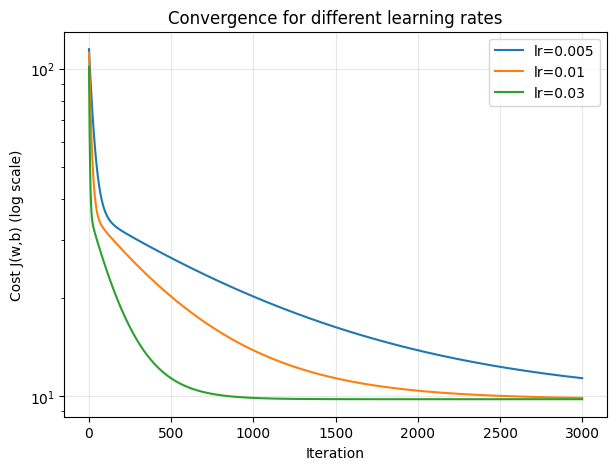

[(0.005, 15.161648302334433, -11.91675567977461, 11.357724839005746),
 (0.01, 17.41363618735943, -15.648024982074759, 9.886214533504132),
 (0.03, 18.127885235458493, -16.831448554239998, 9.795149521328096)]

In [39]:
learning_rates = [0.005, 0.01, 0.03]
iters = 3000

results = []
plt.figure(figsize=(7,5))
for lr in learning_rates:
    w, b, hist = gradient_descent(M, L, lr=lr, iters=iters, use_vectorized=True)
    results.append((lr, w, b, float(hist[-1])))
    plt.plot(hist, label=f'lr={lr}')

plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Cost J(w,b) (log scale)')
plt.title('Convergence for different learning rates')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

results

## 7) Final fit plot + systematic errors (mandatory)
We choose the learning rate with the lowest final loss and plot the fitted line over the data.
Because the true relationship is curved, we expect **systematic errors** (e.g., underpredict at high mass or overpredict in the middle).

In [40]:
best = min(results, key=lambda t: t[3])
best_lr, best_w, best_b, best_loss = best
best_lr, best_w, best_b, best_loss

(0.03, 18.127885235458493, -16.831448554239998, 9.795149521328096)

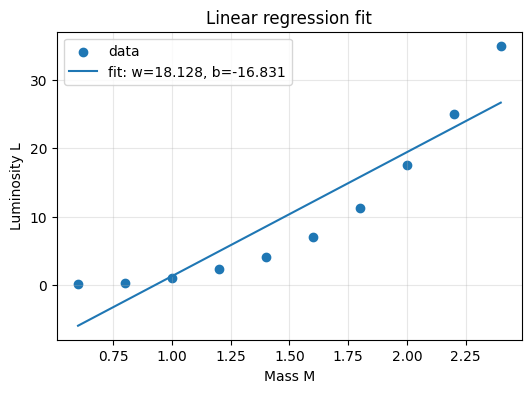

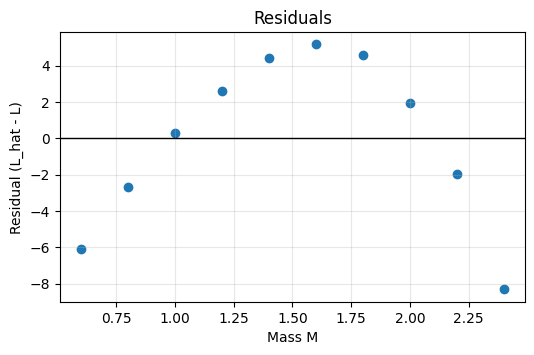

In [46]:
M_line = np.linspace(M.min(), M.max(), 200)
L_line = predict_lin(M_line, best_w, best_b)

plt.figure(figsize=(6,4))
plt.scatter(M, L, label='data')
plt.plot(M_line, L_line, label=f'fit: w={best_w:.3f}, b={best_b:.3f}')
plt.xlabel('Mass M')
plt.ylabel('Luminosity L')
plt.title('Linear regression fit')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

res = predict_lin(M, best_w, best_b) - L
plt.figure(figsize=(6,3.5))
plt.axhline(0, color='k', linewidth=1)
plt.scatter(M, res)
plt.xlabel('Mass M')
plt.ylabel('Residual (L_hat - L)')
plt.title('Residuals')
plt.grid(True, alpha=0.3)
plt.show()

## 8) Conceptual questions
**Q1. What is the astrophysical meaning of $w$?**
In this simplified linear model, $w$ is the *slope* $dL/dM$: how many solar luminosities $L_\odot$ the model predicts per additional solar mass $M_\odot$. It is a crude average sensitivity over the mass range in the dataset.

**Q2. Why is a linear model limited here?**
Main-sequence luminosity grows much faster than linearly with mass (often approximated by a power law). A straight line cannot match the curvature, so it will produce systematic residual patterns and larger errors at the ends of the mass range.